# Udacity Data Scientist Nanodegree
## Project 1: White a Data Science Blog Post
## Stack Overflow: Where and Who?
In this project we will be looking at Stack Overflow [user survey data from 2016-2020](https://insights.stackoverflow.com/survey/) and answering the following questions:
1. In the period 2016-2020, have there been any major shifts in which countries users are from?
2. What is the gender split on Stack Overflow, and have there been any major changes between 2016-2020?
3. Looking at the 2020 data, what are the age distributions of male and female users?

### Data acquisition
Let's start by loading the required python libraries and the survery results from 2016-2020

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Dict of the paths to the results files
results = {
    2016: './Stack Overflow Data/2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Responses.csv',
    2017: './Stack Overflow Data/developer_survey_2017/survey_results_public.csv',
    2018: './Stack Overflow Data/developer_survey_2018/survey_results_public.csv',
    2019: './Stack Overflow Data/developer_survey_2019/survey_results_public.csv',
    2020: './Stack Overflow Data/developer_survey_2020/survey_results_public.csv'
}

In [101]:
dfs = {}  # Empty dict to store all dataframes in

# Read in all the results files into a list with year as the key
for year, path in results.items():
    try:
        dfs[year] = pd.read_csv(path)
        print('Successfully read results file for year: {}'.format(year))
    except:
        print('Could not read results file for year: {}'.format(year))

Successfully read results file for year: 2016
Successfully read results file for year: 2017


/Users/guy/.pyenv/versions/3.9.5/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Successfully read results file for year: 2018
Successfully read results file for year: 2019
Successfully read results file for year: 2020


**Note: Reading the 2018 data raises a warning due to detection of mixed types in many columns. This results in these columns being given the `object` dtype. In this case, it does not affect the analysis, but it may be important in other situations.**

### Question 1: In the period 2016-2020, have there been any major shifts in which countries users are from?
#### Data understanding
To answer this question, we'll start by taking a quick look at the data from a couple of different years.

In [102]:
dfs[2016].head(3)

,Unnamed: 0,collector,country,un_subregion,so_region,age_range,age_midpoint,gender,self_identification,occupation,...,important_sameend,important_newtech,important_buildnew,important_buildexisting,important_promotion,important_companymission,important_wfh,important_ownoffice,developer_challenges,why_stack_overflow
0,1888,Facebook,Afghanistan,Southern Asia,Central Asia,20-24,22.0,Male,Programmer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4637,Facebook,Afghanistan,Southern Asia,Central Asia,30-34,32.0,Male,Developer; Engineer; Programmer,Mobile developer - iOS,...,This is somewhat important,This is very important,This is very important,I don't care about this,This is somewhat important,This is somewhat important,I don't care about this,I don't care about this,Unrealistic expectations; Interacting with non...,To get help for my job; Because I can't do my ...
2,11164,Facebook,Afghanistan,Southern Asia,Central Asia,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
dfs[2020].head(3)

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN


The country column is a categorical variable. To answer this question, we will only be looking at the counts of each of the options (countries), and so we don't need to perform any encoding on the column. This might be needed if the column were to be used as part of an ML model.

We can see that the naming of the column containing the country data isn't consistent: 'Country' vs 'country'. To make it simpler to refer to the column in every dataset, we can convert all the column names to lower case.

In [104]:
# Change all the column titles to lower case to make it easy to refer to them consistently
for year in dfs.keys():
    dfs[year].columns = dfs[year].columns.str.lower()

Now let's check for missing values in the country columns of our datasets.

In [105]:
# Define function to return the number of rows and missing values in a column. Will also be used later in the analysis.
def column_summary(df, column_name, print_summary=False):
    """ Function to return the number of rows and missing values in a column, and optionally print these values.
    
    Args:
        df (pandas DataFrame): DataFrame containing the column of interest
        column_name (str): name of the column of interest
        print_summary (bool): print a sumamry of the column, default False
        
    Returns:
        count_rows (int): number of rows in the column
        count_missing (int): number of missing values in the column
        fraction_missing (float): fraction of rows that are missing values
        Returned as a tuple
    """
    count_rows = df[column_name].shape[0]
    count_missing = df[column_name].isna().sum()
    fraction_missing = count_missing/count_rows
    
    if print_summary==True:
        print("Column '{}' has {} rows and {} missing values ({}%).".format(column_name, count_rows, count_missing, round(100*fraction_missing, 2)))
    
    return (count_rows, count_missing, fraction_missing)

for year, results in dfs.items():
    print(year, end=': ')
    column_summary(results, 'country', print_summary=True)

2016: Column 'country' has 56030 rows and 502 missing values (0.9%).
2017: Column 'country' has 51392 rows and 0 missing values (0.0%).
2018: Column 'country' has 98855 rows and 412 missing values (0.42%).
2019: Column 'country' has 88883 rows and 132 missing values (0.15%).
2020: Column 'country' has 64461 rows and 389 missing values (0.6%).


We can see that there is a very small amount of missing values (<1%), so we should be comfortable using the data in this column. We do not need to explicitly drop these rows, as we will be using `value_counts()` which by default excludes missing data from its counts.

Let's look at some of the country data from one of the years.

In [106]:
# Count the number of unique values in the country column
print("There are {} unique countries in the 2020 dataset.".format(dfs[2020]['country'].value_counts().shape[0]))

# Limit the number of countries to look at
num_countries_to_track = 6

# How much of the data is accounted for by the top countries?
print("The top {} countries make up {} of the respondents.".format(
    num_countries_to_track,
    sum(dfs[2020]['country'].value_counts(normalize=True)[:num_countries_to_track])
    ))

There are 183 unique countries in the 2020 dataset.
The top 6 countries make up 0.5110968909976277 of the respondents.


There are 183 unique countries in the column! But by looking at the normalised value counts we can see that if we just look at the top 6 countries, that covers over half of the respondents.
#### Prepare data
We'll use the top six countries from the most recent survey and see how they've changed since 2016.

In [107]:
# Take the top six countries from the most recent survey, and use them as our countries to track.
countries_of_interest = list(dfs[2020]['country'].value_counts(dropna=True).keys())[:num_countries_to_track]

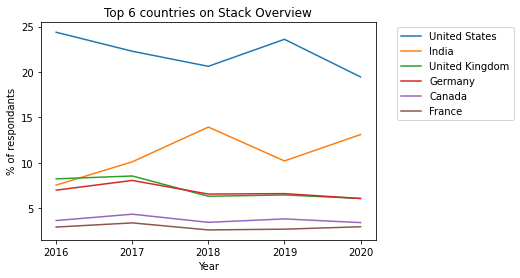

In [108]:
country_data_over_time = {}  # Empty dict to store the country data over time

# Iterate through our results sets
for year, results in dfs.items():
    # Calculate normalised counts, discounting na values
    country_counts = 100*results['country'].value_counts(dropna=True, normalize=True)

    # Iterate through our countries of interest to pull out their data
    country_data_over_time[year] = []
    for country in countries_of_interest:
        country_data_over_time[year].append(country_counts[country])  

# Seperate out the dict into x and y axes
year_values = list(country_data_over_time.keys())
country_values = list(country_data_over_time.values())

# Plot a line chart of the results
plt.xticks(year_values)
plt.xlabel('Year')
plt.ylabel('% of respondants')
plt.plot(year_values, country_values, label=countries_of_interest);
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
plt.title('Top 6 countries on Stack Overview');

**We can see that in the period 2016-2020:**
- **The USA is the country with the most respondents, by far.**
- **The USA has decreased from approx. 24% of users to approx. 19% of respondents.**
- **In the same time, India has increased from approx. 8% to 13% of respondents.**

There's an interesting fluctuation in the data in 2018/2019; it would be interesting to find out the cause of this!

---

### Question 2: What is the gender split on Stack Overflow, and have there been any major changes between 2016-2020?
#### Data understanding
To answer this question, we'll start by taking a quick look at the data from a couple of different years.

In [109]:
dfs[2016]['gender'].value_counts()

Male                      51388
Female                     3202
Prefer not to disclose      722
Other                       274
Name: gender, dtype: int64

In [110]:
dfs[2020]['gender'].value_counts()

Man                                                            46013
Woman                                                           3844
Non-binary, genderqueer, or gender non-conforming                385
Man;Non-binary, genderqueer, or gender non-conforming            121
Woman;Non-binary, genderqueer, or gender non-conforming           92
Woman;Man                                                         76
Woman;Man;Non-binary, genderqueer, or gender non-conforming       26
Name: gender, dtype: int64

The way gender has been recorded has changed multiple times in the period 2016-2020, which poses challenges when comparing the data. For the sake of this analysis, we will be categorising the data into three buckets: Male/Man, Female/Woman, and Non-Binary (acknowledging that this is an umbrella term for many distinct gender identities).

Gender is a categorical variable. No encoding is required in this case, as we're simply counting the instances of each response.

Let's also check for missing values.

In [111]:
for year, results in dfs.items():
    print(year, end=': ')
    column_summary(results, 'gender', print_summary=True)

2016: Column 'gender' has 56030 rows and 444 missing values (0.79%).
2017: Column 'gender' has 51392 rows and 16345 missing values (31.8%).
2018: Column 'gender' has 98855 rows and 34386 missing values (34.78%).
2019: Column 'gender' has 88883 rows and 3477 missing values (3.91%).
2020: Column 'gender' has 64461 rows and 13904 missing values (21.57%).


We can see that in some years (2016, 2019), there are very few missing values. In others (2017, 2018, 2020), there is a large fraction missing. To ensure we get meaningful results we will have to drop the rows with missing values.
#### Prepare data
We will start by cleaning the data by dropping missing values, and then calculate the fraction of respondents that fall into each category.

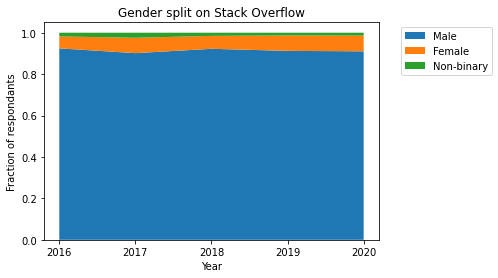

In [112]:
gender_data_over_time = {}  # Empty dict to store the gender data over time

# Iterate through our results sets
for year, results in dfs.items():
    gender_data_clean = results['gender'].dropna() # Drop missing values
    num_respondants = gender_data_clean.shape[0] # Number of respondents
    
    # Get the fraction of respondants that selected only 'Male'/'Man' or 'Female'/'Woman'
    male_fraction = gender_data_clean[(gender_data_clean == 'Male') | (gender_data_clean == 'Man')].shape[0]/num_respondants
    female_fraction = gender_data_clean[(gender_data_clean == 'Female') | (gender_data_clean == 'Woman')].shape[0]/num_respondants
    
    # Remaining fraction is respondants who selected other or multiple options
    nb_fraction = 1 - (male_fraction + female_fraction)
    
    gender_data_over_time[year] = [male_fraction, female_fraction, nb_fraction]
    
# Seperate out the dict into x and y axes
year_values = list(gender_data_over_time.keys())
gender_values = list(gender_data_over_time.values())

# Transpose the data to get in the correct format for plotting with stackplot
gender_values = np.array(gender_values).T.tolist()

# Plot a stacked area chart of the results
plt.xticks(year_values)
plt.xlabel('Year')
plt.ylabel('Fraction of respondants')
plt.stackplot(year_values, gender_values, labels=['Male', 'Female', 'Non-binary']);
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
plt.title('Gender split on Stack Overflow');

We can see that the Stack Overflow surverys are predominantly answered by respondents who identify as male (90%+).

In the chart above it is difficult to determine if there are any trends. Let's replot it with the y-axis scaled to show more detail.

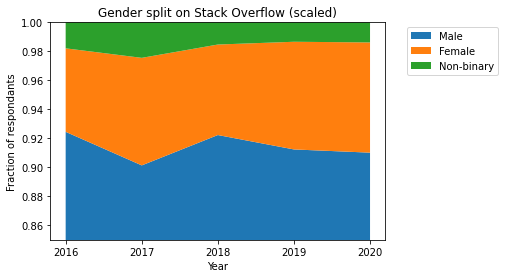

In [113]:
# Plot a stacked area chart of the results, with the y-axis scaled to help show any trends
plt.xticks(year_values)
plt.xlabel('Year')
plt.ylabel('Fraction of respondants')
plt.ylim([0.85, 1.0]) # Scale the y-axis to zoom in
plt.stackplot(year_values, gender_values, labels=['Male', 'Female', 'Non-binary']);
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
plt.title('Gender split on Stack Overflow (scaled)');

**We can see that in the period 2016-2020:**
- **The way in which the survery asked users about their gender changed significantly.**
- **Survey respondents predominantly identify as male.**
- **There are no clear trends showing changes in the gender split on Stack Overflow.**

---

### Question 3: Looking at the 2020 data, what are the age distributions of male and female users?
We have seen that the majority of respondents are male, but how does this correlate with age?
#### Data understanding
For this question we will be looking at the relationship between two columns, so we need to remove any rows in which either the gender or the age are missing. Let's check how much of the data that is.

In [114]:
df_age_gender = dfs[2020][['age', 'gender']]  # Extract DataFrame with the year and columns we're interested in

# Print summaries of the missing data in the age and gender columns individually
num_rows, _, _ = column_summary(df_age_gender, 'gender', print_summary=True)
column_summary(df_age_gender, 'age', print_summary=True)

# Calculate and print the number of rows in which either the age or gender is missing
num_missing = df_age_gender[df_age_gender['age'].isna() | df_age_gender['gender'].isna()].shape[0]
print("Of {} rows, there are {} is which either age or gender data is missing ({}%)".format(num_rows, num_missing, round(100*num_missing/num_rows, 2)))

Column 'gender' has 64461 rows and 13904 missing values (21.57%).
Column 'age' has 64461 rows and 19015 missing values (29.5%).
Of 64461 rows, there are 19625 is which either age or gender data is missing (30.44%)


We can see that just over 30% of the rows have either age or gender data missing.
#### Prepare data
Let's drop these rows, and then take a look at a summary of the age column.

In [115]:
# Remove rows where either gender or age are null
df_age_gender = df_age_gender.dropna(how='any')

# Let's have a quick look at the age data
df_age_gender['age'].describe()

count    44836.000000
mean        30.821382
std          9.534412
min          1.000000
25%         24.000000
50%         29.000000
75%         35.000000
max        279.000000
Name: age, dtype: float64

Wow, a there's 279 year-old Stack Overflow user! But it's more likely that they've made a mistake (or lied). The oldest living person in the world (at the time of writing) is [118 years-old](https://en.wikipedia.org/wiki/List_of_the_verified_oldest_people), so let's remove any rows claiming to be older than that.

In [116]:
# Drop rows where the age is greater than the oldest living person
df_age_gender.drop(df_age_gender[df_age_gender['age'] > 118].index, inplace=True)
# Check the new maximum age in the dataset
df_age_gender['age'].max()

99.0

We've still got some pretty old Stack Overflowers, but let's give them the benefit of the doubt. Let's have a look at the median age of male and female respondents.

In [117]:
print("Median male age is {}.".format(df_age_gender[df_age_gender['gender'] == 'Man']['age'].median()))
print("Median female age is {}.".format(df_age_gender[df_age_gender['gender'] == 'Woman']['age'].median()))

Median male age is 29.0.
Median female age is 28.0.


It looks like there's a slight skew for women to be younger. Let's explore this further by making a population pyramid. To do this we need to bin the data into age brackets.

In [118]:
# Define our bins and some human-readable labels for them
age_bins = range(10, 81, 5)
age_labels = [
    '11-15',
    '16-20',
    '21-25',
    '26-30',
    '31-35',
    '36-40',
    '41-45',
    '46-50',
    '51-55',
    '56-60',
    '61-65',
    '66-70',
    '71-75',
    '76-80'
]

# Add a new column containing the age bin the respondent falls in
df_age_gender['age bin'] = pd.cut(df_age_gender['age'], bins=age_bins, labels=age_labels)

# Count how many falls into each bin, splitting by men and women
binned_data_man = df_age_gender[df_age_gender['gender'] == 'Man'].groupby('age bin').count()['gender']
binned_data_woman = df_age_gender[df_age_gender['gender'] == 'Woman'].groupby('age bin').count()['gender']

We know from looking at the gender split over time that Stack Overflow is male-dominated, so we need to normalise our binned data so that we can compare them meaningfully.

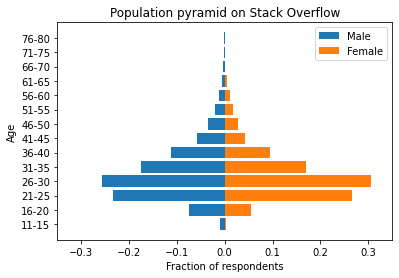

In [119]:
# Normalise the binned data. We'll also make the male data negative for plotting
binned_data_man_normalised = binned_data_man.div(-binned_data_man.sum())
binned_data_woman_normalised = binned_data_woman.div(binned_data_woman.sum())

# Plot the two data sets on a horizonal bar chart
plt.barh(age_labels, binned_data_man_normalised, label='Male');
plt.barh(age_labels, binned_data_woman_normalised, label='Female');
plt.xlim([-0.35, 0.35]);
plt.xlabel('Fraction of respondents');
plt.ylabel('Age');
plt.legend();
plt.title('Population pyramid on Stack Overflow');

We can see that there appears to be a greater proportion of female respondents in the younger age brackets. To make this easier to see, let's subtract the male dataset from the female dataset and look at the differences.

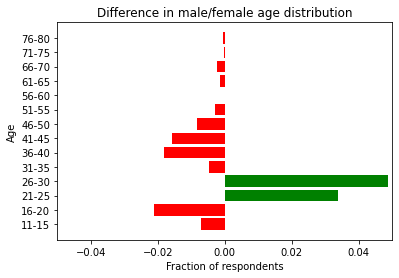

In [120]:
# Adding, as we've made the male dataset negative for plotting
binned_data_differences = binned_data_man_normalised.add(binned_data_woman_normalised)

# For formatting purposes
difference_is_positive = binned_data_differences > 0

# Plot the data on a horizonal bar chart
plt.barh(age_labels, binned_data_differences, color=difference_is_positive.map({True: 'g', False: 'r'}));
plt.xlim([-0.05, 0.05]);
plt.xlabel('Fraction of respondents');
plt.ylabel('Age');
plt.title('Difference in male/female age distribution');

**There are some clear differences in the age distributions of men and women on Stack Overflow:**
- **Compared to the male respondents, the age of female respondents has a narrower distribution, peaking in the 21-30 age bracket.**
- **This peak falls off rapidly either side of this age bracket.**
- **Combined with Question 2, this indicates that there are fewer female Stack Overflow users, and they are earlier in their careers.**

---

## Conclusion
In this notebook we have looked at Stack Overflow user survey data from 2016-2020 and found the following:
1. In the period 2016-2020, **there has been an increase in users from India, and a decrease in users from the USA.**
2. **Survey respondents predominantly identify as male (over 90%)**, and there are **no clear trends over time.**
3. In the 2020 data **the age distribution of female users has a narrower spread, and peaks in the 21-30 age bracket. This could indicate women earlier in their careers.**